In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import FinancialMachineLearning as fml

### Chapter 7. Cross-Validation in Finance

#### Exercise 1

금융에 있어서 K-Fold Cross Validation을 수행하기 전에 데이터셋을 섞는 것이 일반적으로 좋지 않은 이유는 무엇인가?데이터를 Shuffling하는 목적은 무엇인가? 데이터를 Shuffling하면 금융 데이터셋에 있어 K-Fold Cross Validation의 목적이 무의미해지는 이유는 무엇인가?

답 : 우리가 사용하는 금융 시계열 데이터셋인데, 만약 데이터셋을 섞게 된다면 순차적 시간 정보다 뒤섞이게 된다. 이는 오히려 추정기의 성능을 떨어뜨리는 결과를 낳게 된다. 일반적으로 Data Science 분야에서 교차 검증을 위해 데이터를 섞는 이유는 무작위 표본 추출로 test, validation, train set을 선택하기 위함인데, 금융 시계열 데이터에서는 Shuffling을 한다면 시간 정보가 사라지고, information leak 등의 다양한 문제가 발생하게 되어 결과적으로 목적이 무의미해진다.

#### Exercise 2

관측된 특성과 레이블로 구성된 한 쌍의 행렬$(X,y)$을 하나 구하자. 3장 연습 문제에서 도출한 데이터셋 중 하나를 사용해도 된다.

In [2]:
df = pd.read_csv('sp500featureBin.csv', index_col = 0)
df

,dollar,frac_diff_dollar,tW,w,bin
2009-11-04 14:41:43,50.4500,0.529761,0.750000,1.984399,-1.0
2009-11-04 15:43:57,49.8800,-0.137134,0.444444,0.077423,1.0
2009-11-05 09:46:35,50.2080,0.349295,0.388889,3.523273,1.0
2009-11-06 10:39:27,50.5448,0.038635,0.333333,3.626638,1.0
2009-11-06 12:37:18,50.9232,0.559177,0.333333,2.644159,1.0
...,...,...,...,...,...
2018-09-26 10:07:41,116.5780,0.334817,0.209694,0.813016,-1.0
2018-09-26 15:47:29,115.9960,0.220088,0.189087,0.495700,1.0
2018-09-27 10:02:15,116.1100,0.750801,0.176905,0.055908,-1.0
2018-09-27 15:39:35,115.9000,0.349971,0.166905,0.621259,1.0


In [3]:
X = df.iloc[:,:-1].values # dollar, frac_diff, tW, w
y = df.iloc[:,-1].values.reshape(-1,1) # bin

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, random_state = 42)

**(a)** $(X,y)$에 대해 데이터를 Shuffling하지 않고 Random Forest Classifier의 10 Fold Cross Validation의 성능을 도출해 보라

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train.reshape(1,-1))
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train.reshape(-1,))

In [6]:
cweight = pd.DataFrame()
cweight.index = df.index
cweight['class_weight'] = np.nan
cweight.loc[df[df.bin == -1.0].index] = weights[1]
cweight.loc[df[df.bin == 1.0].index] = weights[0]
cweight

,class_weight
2009-11-04 14:41:43,0.888158
2009-11-04 15:43:57,1.144068
2009-11-05 09:46:35,1.144068
2009-11-06 10:39:27,1.144068
2009-11-06 12:37:18,1.144068
...,...
2018-09-26 10:07:41,0.888158
2018-09-26 15:47:29,1.144068
2018-09-27 10:02:15,0.888158
2018-09-27 15:39:35,1.144068


In [7]:
#based on book recommendation
rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state=42, class_weight = 'balanced_subsample', oob_score=False)
cv_gen = KFold(n_splits = 10, shuffle = False)
score = fml.cvScore(rf, X, y, sample_weight = cweight, scoring = 'neg_log_loss', cv = None, cvGen = cv_gen, pctEmbargo = 0)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.717943
CV Variance: 0.006818


**(b)** $(X,y)$에 대해 데이터를 섞으며 Random Forest Classifier의 10 Fold Cross Validation의 검증 성능을 도출해 보라

In [8]:
cv_gen0 = KFold(n_splits = 10, random_state = 42, shuffle = True)

score = fml.cvScore(rf, X, y, sample_weight = cweight, scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.556278
CV Variance: 0.000234


**(c)** 두 결과가 많이 다른 이유는 무엇인가?

**(d)** 데이터를 Shuffling하면 Information Leak이 어떻게 일어나는가?

#### Exercise 3
Exercise 2에서 사용한 것과 동일한 $(X,y)$행렬을 사용하자

**(a)** $(X,y)$에 대해 1% Embargo를 사용한 Random Forest Classifier의 10 Fold Purged Cross Validation의 검증 성능을 도출해 보라

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn import metrics
from scipy import interp

In [10]:
rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state=42, class_weight = 'balanced_subsample', oob_score=False)

cv_gen0 = KFold(n_splits = 10, shuffle = False)

score = fml.cvScore(rf, X, y, sample_weight = cweight, scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.717943
CV Variance: 0.006818


**Add Ons**
scoreVal plot : BlackArbsCEO

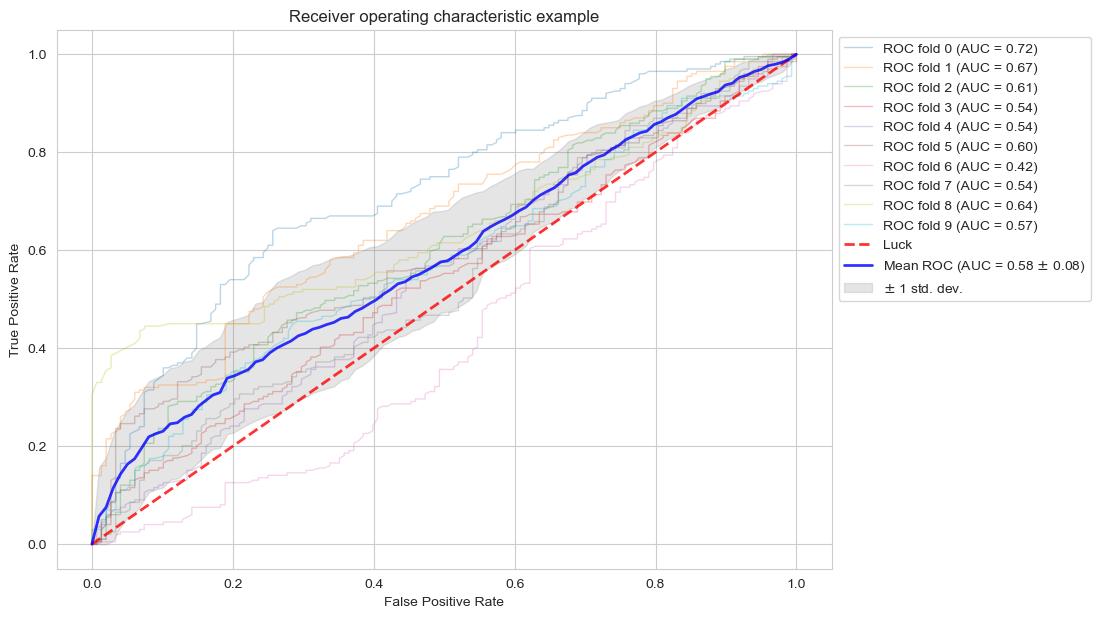

In [11]:
skf = StratifiedKFold(n_splits=10, shuffle = False)
classifier = RandomForestClassifier(n_estimators = 1000, criterion='entropy', bootstrap = True,
                                    class_weight='balanced_subsample', random_state = 42, oob_score=False)
fml.crossValPlot(skf, classifier, X,y)

**(b)** 왜 성능이 더 낮아졌는가?

Train Set과 Test Set 사이에 중첩된 결과들이 존재하던 부분을 Embargo를 통해 제외하였기 때문이다

**(c)** 이 결과가 더 현실적인 이유는 무엇인가?

중첩 Labeling된 사건들을 제외하였기 때문에 Feature내의 데이터들은 통계학에서의 IID가정을 더 잘 지키게 된다. 따라서, Information Leak이 더 적은 상태이기 때문에 이 결과가 더 현실적이라고 할 수 있다

#### Example 4

7장에서 K Fold Cross Validation이 금융 응용에서 실패한 한 가지 이유에 집중했다. 즉, 테스트셋의 특정 정보가 훈련셋으로 누출되는 현상이었다. 교차 검증 실패의 두 번째 이유도 생각할 수 있겠는가?

In [12]:
rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state=42, class_weight = 'balanced_subsample', oob_score=False)

cv_gen0 = KFold(n_splits = 10, shuffle = True)

score = fml.cvScore(rf, X, y, sample_weight = cweight, scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.01)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.559525
CV Variance: 0.000498


K Fold 검증 과정에서 Test Data Set은 Train Data를 순차적으로 거치면서 여러번 사용되게 된다. 이 과정에서 Test Data로 사용되었던 것을 Train Data로 한번 더 사용하면서, Selection Bias가 발생하게 된다. 즉, 편향된 결과는 제거되어야 하는데 여러번 Train과정에 사용되기 때문에 편향된 정보에 최적화되게 된다. 따라서 K Fold 검증의 사용 이유를 잃어버리게 된다

#### Exercise 5

동일한 투자 전략에서 1,000가지 설정을 테스트하고자 각각에 대해 Cross Validation을 수행한다고 가정해 보자. 어떤 결과는 괜찮아 보인다. 이런 양성적 결과만 게재하고 나머지를 감춘다면 청중들은 이런 결과가 잘못된 양성이라는 것을 추론할 수 없을 것이고, 이는 통계적 요행이 된다. 이런 현상을 `Selection Bias`라고 부른다.

**(a)** 이를 막을 수 있는 절차 하나를 생각할 수 있겠는가?

**(b)** 데이터셋을 세 가지, 즉 훈련, 검증, 테스트로 나누면 어떻게 될까? 검증셋은 학습된 파라미터를 평가하고자 사용하고, 테스트는 검증 단계에서 선택된 하나의 설정에 대해서만 수행한다. 어떤 경우에 이런 절차가 여전히 실패하게 될까?

**(c)** 선택 편향을 피할 수 있는 핵심은 무엇인가?